# Convolutional Neural Networks on CIFAR10 dataset

- CIFAR-10 is a dataset that consists of several images divided into the following 10 classes:
    - Airplanes
    - Cars
    - Birds
    - Cats
    - Deer
    - Dogs
    - Frogs
    - Horses
    - Ships
    - Trucks

- The dataset stands for the Canadian Institute For Advanced Research (CIFAR)
- CIFAR-10 is widely used for machine learning and computer vision applications.
- The dataset consists of 60,000 32x32 color images and 6,000 images of each class.
- Images have low resolution (32x32).
- Data Source: https://www.cs.toronto.edu/~kriz/cifar.html

The Challenge here for the model is extreme low resolutions of the images

## Library imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Note this code is only valid if GPU is being used for training

# Before we run the parameter tuning, we will work with little gpu memory allocation
# we will only use that much of memory of gpu as it is needed - allow the growth of gpu memory as it is needed

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Load the Dataset

In [3]:
# load the data
(features_train, target_train), (features_test, target_test) = cifar10.load_data()
# Let's check the shape of the respective sets
print(f"Shape of the Training features: {features_train.shape}")
print(f"Shape of the Testing features: {features_test.shape}")
print(f"Shape of the Training labels: {target_train.shape}")
print(f"Shape of the Testing labels: {target_test.shape}")

170498071/170498071 [==============================] - 15s 0us/step
Shape of the Training features: (50000, 32, 32, 3)
Shape of the Testing features: (10000, 32, 32, 3)
Shape of the Training labels: (50000, 1)
Shape of the Testing labels: (10000, 1)


## Data Visualizations

Class of the image - [9]


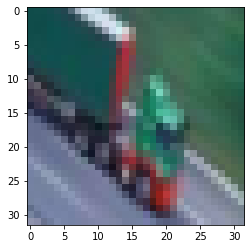

In [4]:
# We will check the 50th image
plt.imshow(features_train[50])
print(f"Class of the image - {target_train[50]}")

c:\Users\SuvoB\.conda\envs\tensorflow-gpu\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


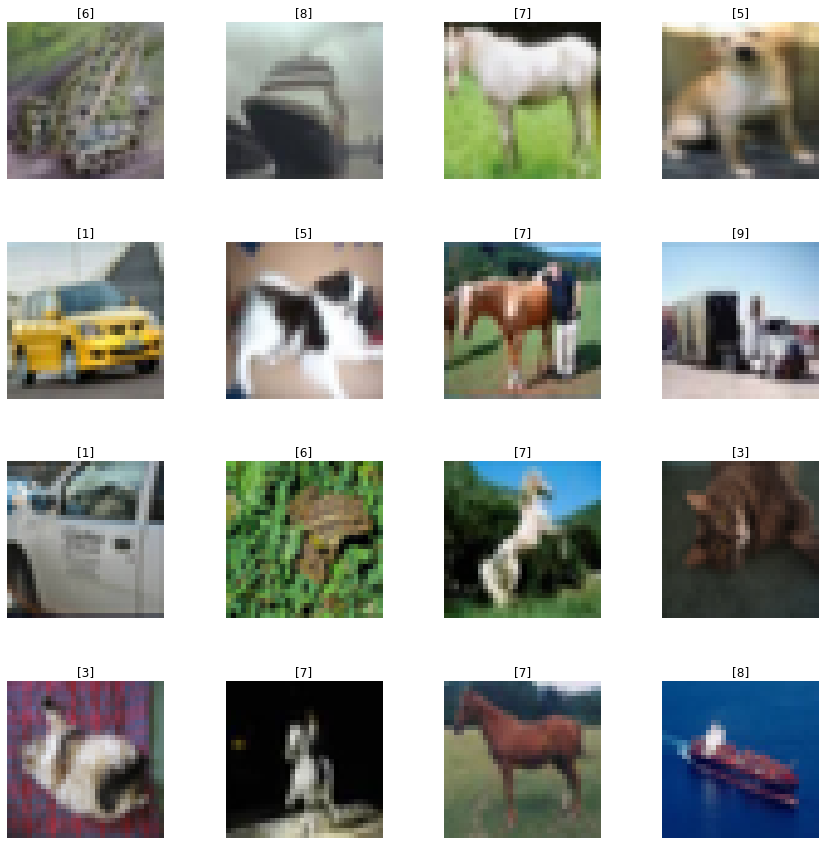

In [5]:
# Lets view some 16 images

W_grid = 4
L_grid = 4

fig, axes = plt.subplots(L_grid, W_grid, figsize = (15, 15))
axes = axes.ravel()

n_training = len(features_train)

for i in np.arange(0, L_grid * W_grid):
    index = np.random.randint(0, n_training) # pick a random number
    axes[i].imshow(features_train[index])
    axes[i].set_title(target_train[index])
    axes[i].axis('off')

plt.subplots_adjust(hspace = 0.4)

## Data Preparation for CNN

In [6]:
# We will need to convert the datatypes of training and testing features to float32
features_train = features_train.astype('float32')
features_test = features_test.astype('float32')

In [7]:
# Normalize the training and test features
features_train = features_train/255
features_test = features_test/255

In [8]:
# In order to use categorical cross entropy, we need to convert the target variable to categorical
target_train = tf.keras.utils.to_categorical(target_train, num_classes=10)
target_test = tf.keras.utils.to_categorical(target_test, num_classes=10)

In [9]:
# Check the training features
features_train

array([[[[0.23137255, 0.24313726, 0.24705882],
         [0.16862746, 0.18039216, 0.1764706 ],
         [0.19607843, 0.1882353 , 0.16862746],
         ...,
         [0.61960787, 0.5176471 , 0.42352942],
         [0.59607846, 0.49019608, 0.4       ],
         [0.5803922 , 0.4862745 , 0.40392157]],

        [[0.0627451 , 0.07843138, 0.07843138],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509805, 0.21568628],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117648, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215687, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941177, 0.19607843],
         [0.47058824, 0.32941177, 0.19607843],
         [0.42745098, 0.28627452, 0.16470589]],

        ...,

        [[0.8156863 , 0.6666667 , 0.3764706 ],
         [0.7882353 , 0.6       , 0.13333334]

In [10]:
# Check the training target
target_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

## Build and Train the Model

In [11]:
# Build the Model
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.keras.activations.relu, input_shape=features_train.shape[1:]))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.keras.activations.relu))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
cnn.add(tf.keras.layers.Dropout(0.3))

cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3)))
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3)))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
cnn.add(tf.keras.layers.Dropout(0.3))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(units=1024, activation=tf.keras.activations.relu))
cnn.add(tf.keras.layers.Dropout(0.3))
cnn.add(tf.keras.layers.Dense(units=1024, activation=tf.keras.activations.relu))
cnn.add(tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax))

# Compile the Model
cnn.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        36928     
                                                        

In [12]:
# Train the Model
start = datetime.datetime.now()
print(f"Training Begins at - {start}")
print("\n")
cnn.fit(features_train, target_train, batch_size=512, epochs=100)
print("\n")
end = datetime.datetime.now()
print(f"Training ends at - {end}")
print(f"Total Training time - {end - start}")

Training Begins at - 2022-08-07 14:58:37.293002


Epoch 1/100
98/98 [==============================] - 18s 22ms/step - loss: 2.0356 - accuracy: 0.2504
Epoch 2/100
98/98 [==============================] - 2s 19ms/step - loss: 1.6845 - accuracy: 0.3884
Epoch 3/100
98/98 [==============================] - 2s 19ms/step - loss: 1.5204 - accuracy: 0.4457
Epoch 4/100
98/98 [==============================] - 2s 19ms/step - loss: 1.4302 - accuracy: 0.4842
Epoch 5/100
98/98 [==============================] - 2s 19ms/step - loss: 1.3687 - accuracy: 0.5062
Epoch 6/100
98/98 [==============================] - 2s 19ms/step - loss: 1.3193 - accuracy: 0.5273
Epoch 7/100
98/98 [==============================] - 2s 19ms/step - loss: 1.2790 - accuracy: 0.5423
Epoch 8/100
98/98 [==============================] - 2s 19ms/step - loss: 1.2426 - accuracy: 0.5591
Epoch 9/100
98/98 [==============================] - 2s 19ms/step - loss: 1.2069 - accuracy: 0.5727
Epoch 10/100
98/98 [=============================

## Model Evaluation

In [13]:
# We will analyse the two keys of the model
cnn.history.history.keys()

dict_keys(['loss', 'accuracy'])

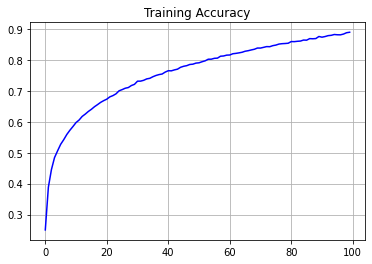

In [15]:
# Plot training accuracy throughout the model
epochs = range(len(cnn.history.history['accuracy']))
plt.plot(epochs, cnn.history.history['accuracy'], 'b', label='Training Accuracy')
plt.title("Training Accuracy")
plt.grid(True)

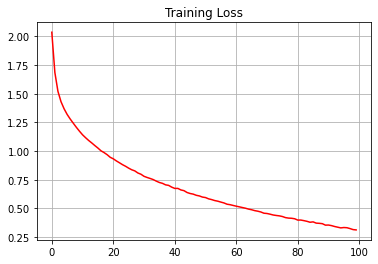

In [17]:
# We will now plot the training Loss
epochs = range(len(cnn.history.history['loss']))
plt.plot(epochs, cnn.history.history['loss'], 'r', label='Training Loss')
plt.title("Training Loss")
plt.grid(True)

In [19]:
# Find the accuracy on the overall test features (images)
score = cnn.evaluate(features_test, target_test, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 0.7724 - accuracy: 0.7643


In [20]:
print(f"Test Accuracy - {score[1]}")

Test Accuracy - 0.7642999887466431


In [27]:
# Now we will run the prediction of classes
predict_x = cnn.predict(features_test)
predicted_classes = np.argmax(predict_x, axis=1)
predicted_classes

313/313 [==============================] - 1s 2ms/step


array([3, 8, 8, ..., 5, 1, 7], dtype=int64)

In [24]:
# Convert back to labels from categories matrix for the actual target labels
target_test = target_test.argmax(axis=1)
target_test

array([3, 8, 8, ..., 5, 1, 7], dtype=int64)

Print the Confusion Matrix

[[792  17  26  12  17   4  15  12  77  28]
 [ 14 867   4   2   3   3  11   1  25  70]
 [ 52   4 621  67  92  45  71  22  16  10]
 [ 18   9  45 600  70 122  75  25  17  19]
 [ 12   2  41  54 759  17  59  39  10   7]
 [ 13   2  29 182  52 624  36  48   5   9]
 [  6   5  17  46  17  16 882   2   5   4]
 [ 17   1  18  38  57  45  10 797   4  13]
 [ 42  24   4  11   7   2  11   0 875  24]
 [ 29  69   3  14   5   2  12   6  34 826]]


<AxesSubplot:>

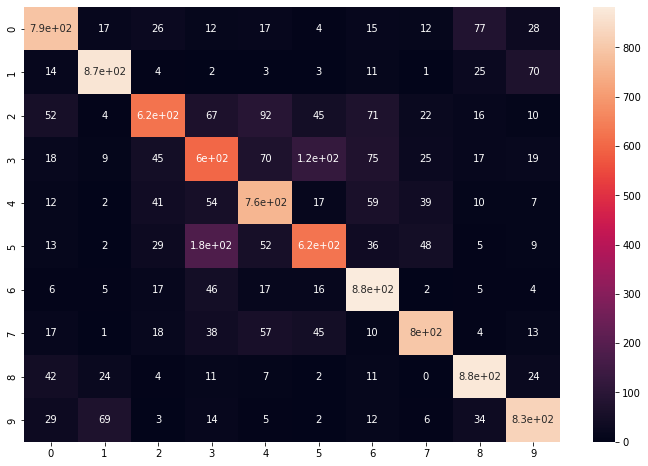

In [25]:
print(f"Print the Confusion Matrix\n")
cm = confusion_matrix(target_test, predicted_classes)
print(cm)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True)

In [26]:
print("Classification Report\n")
print(classification_report(target_test, predicted_classes))

Classification Report

              precision    recall  f1-score   support

           0       0.80      0.79      0.79      1000
           1       0.87      0.87      0.87      1000
           2       0.77      0.62      0.69      1000
           3       0.58      0.60      0.59      1000
           4       0.70      0.76      0.73      1000
           5       0.71      0.62      0.66      1000
           6       0.75      0.88      0.81      1000
           7       0.84      0.80      0.82      1000
           8       0.82      0.88      0.85      1000
           9       0.82      0.83      0.82      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000

